### Load the data using pandas (downloaded the dataset from kaggle)

In [1]:
import pandas as pd

housing_data = pd.read_csv("./housing.csv")

housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### EDA of the dataset

#### The "Big Picture" (Data Integrity)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proxim

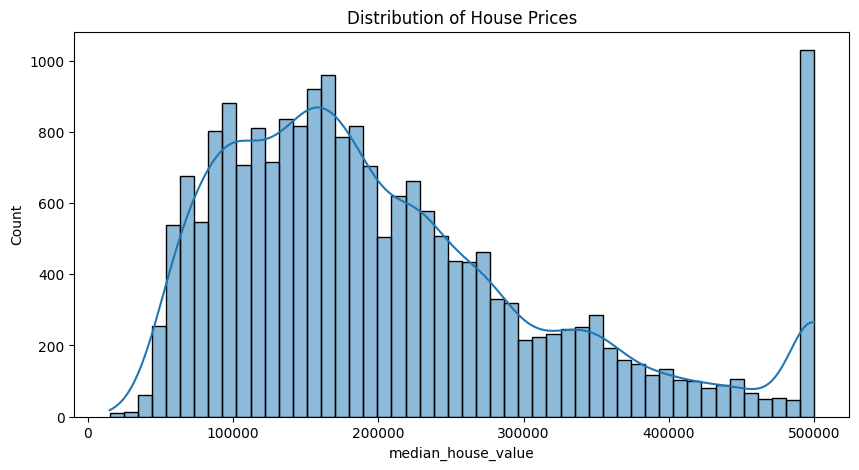

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Check for missing values and data types
print(housing_data.info())
print(housing_data.isna().sum())

# 2. Look at the target variable distribution
plt.figure(figsize=(10, 5))
sns.histplot(housing_data['median_house_value'], bins=50, kde=True)
plt.title('Distribution of House Prices')
plt.show()

#### Geographical Analysis (The "Location" Feature)

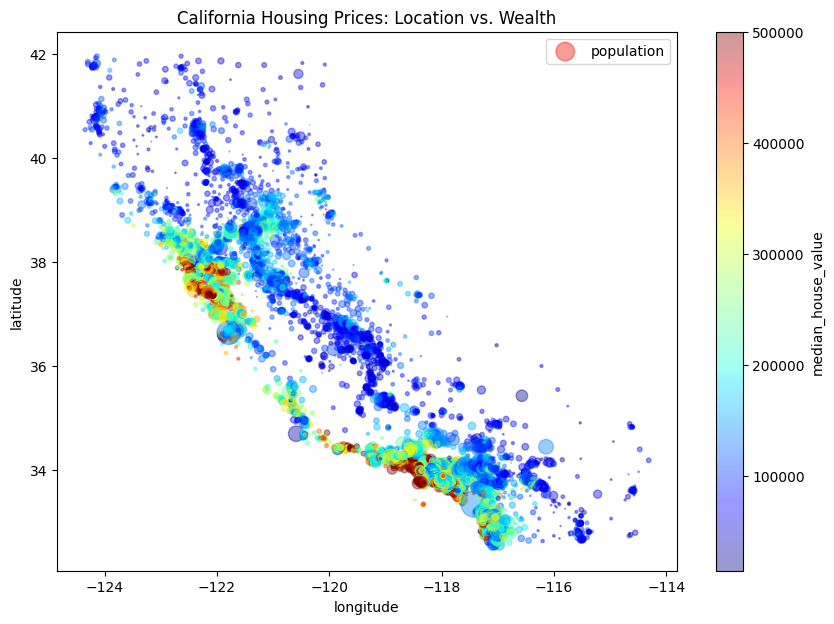

In [3]:
# Visualize prices geographically
housing_data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
        s=housing_data["population"]/100, label="population", figsize=(10,7),
        c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.title("California Housing Prices: Location vs. Wealth")
plt.legend()
plt.show()

#### Correlation: Finding the "Signal"

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


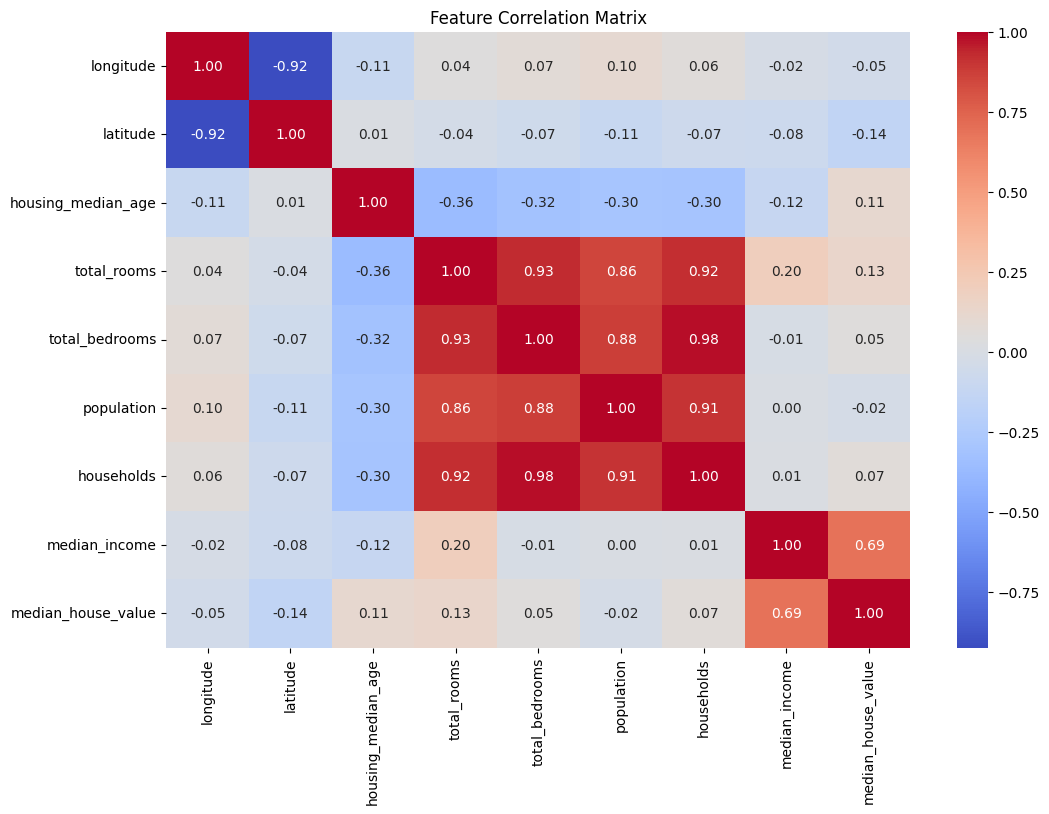

In [4]:
# Compute the correlation matrix
corr_matrix = housing_data.corr(numeric_only=True)

# Look at how much each attribute correlates with the median house value
print(corr_matrix["median_house_value"].sort_values(ascending=False))

# Heatmap for visualization
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

#### The Scatter Matrix (Spotting Non-Linearity)

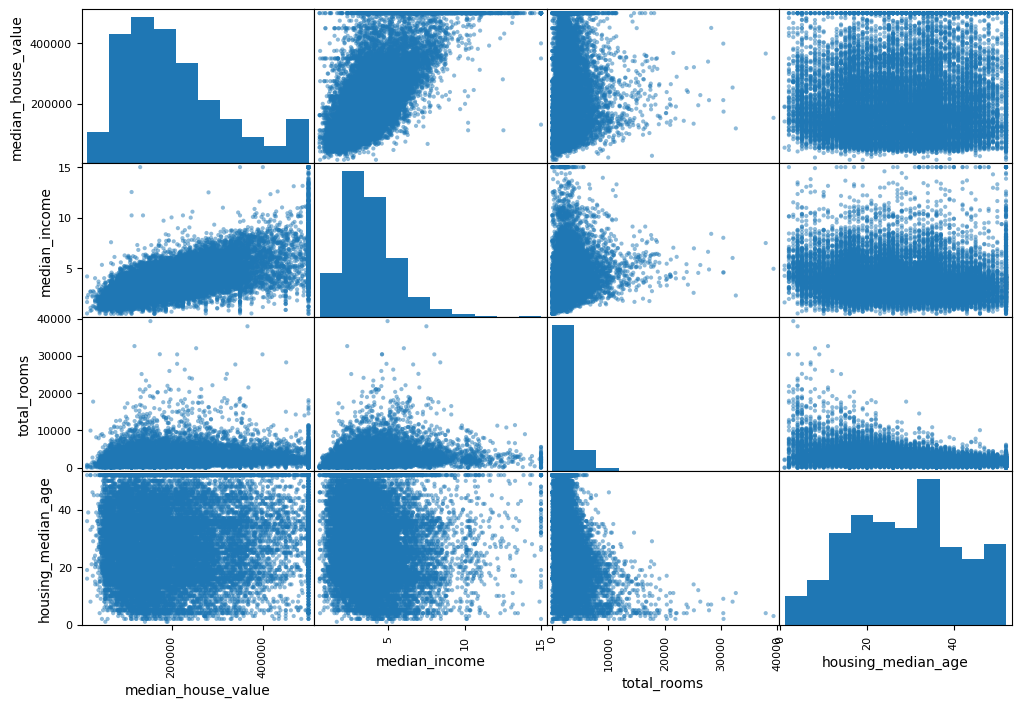

In [5]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing_data[attributes], figsize=(12, 8))
plt.show()

### Preprocessing pipeline

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#### 1. Identify the Columns
First, we separate the features based on how they need to be treated.

In [7]:
# Identify numerical and categorical columns
# Note: 'total_bedrooms' often has missing values in this dataset
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", 
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

#### 2. Split the dataset into Training and Testing datasets

In [8]:
from sklearn.model_selection import train_test_split

# Get the data into features and target 
X, y = housing_data.drop("median_house_value", axis=1), housing_data["median_house_value"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 3. Featuring engineering function

In [9]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

def add_extra_features(X):
    # X is a numpy array. Based on your dataframe order:
    # 0: long, 1: lat, 2: age, 3: rooms, 4: bedrooms, 5: pop, 6: households
    
    # Avoid division by zero by adding a tiny epsilon
    rooms_per_household = X[:, 3] / (X[:, 6] + 1e-6)
    pop_per_household = X[:, 5] / (X[:, 6] + 1e-6)
    bedrooms_per_room = X[:, 4] / (X[:, 3] + 1e-6)
    
    # Stack the new features onto the original array
    return np.c_[X, rooms_per_household, pop_per_household, bedrooms_per_room]

#### 4. The Numerical Pipeline: Imputing & Scaling
Numerical data often has missing values. We use a SimpleImputer to fill gaps with the median (more robust than the mean for skewed data) before scaling.

In [10]:
# Define the Numerical Pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # Handle missing values
    ('feature_engineering', FunctionTransformer(add_extra_features)),
    ('std_scaler', StandardScaler()),              # Scale features
])

#### 5. The Categorical Pipeline: One-Hot Encoding (combined with the numeric pipeline)
Machine learning models can't read "NEAR OCEAN" or "INLAND." We use OneHotEncoder to turn these into binary columns (1s and 0s).

In [11]:
# Combine both into a ColumnTransformer
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

#### 6. Fit and transform the Training and Testing data

In [12]:
# Fit and transform the training data
# This learns the medians and means from X_train ONLY
X_train_prepared = full_pipeline.fit_transform(X_train)

# Transform the test data
X_test_prepared = full_pipeline.transform(X_test)

print(f"Original features: {X_train.shape[1]}")
print(f"Features after engineering: {X_train_prepared.shape[1]}")

Original features: 9
Features after engineering: 16


In [13]:
# Get the names of the one-hot encoded columns
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_features = list(cat_encoder.get_feature_names_out())

# Combine all names
all_feature_names = num_attribs + ["rooms_per_h", "pop_per_h", "bedrooms_per_r"] + cat_one_hot_features
print(all_feature_names)
print(len(all_feature_names))

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_h', 'pop_per_h', 'bedrooms_per_r', 'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']
16


### Implement basline model 

In [14]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

# 1. Create the 'Average' Baseline
# We fit on the Prepared Training Data from our Pipeline
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_prepared, y_train)

# 2. Predict and Calculate Error
y_baseline_pred = dummy_regr.predict(X_test_prepared)
baseline_mae = mean_absolute_error(y_test, y_baseline_pred)

print(f"Baseline MAE: {baseline_mae:.4f}")
print(f"In real dollars: ${baseline_mae * 100000:,.2f}")

Baseline MAE: 90606.8549
In real dollars: $9,060,685,490.01


### Implement linear regression and random forest model

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier # We'll use Regressor for housing
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# 1. Linear Regression CV
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, X_train_prepared, y_train,
                             scoring="neg_mean_absolute_error", cv=10)
lin_mae_scores = -lin_scores

# 2. Random Forest CV (Using a small number of trees for speed initially)
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_reg, X_train_prepared, y_train,
                                scoring="neg_mean_absolute_error", cv=10)
forest_mae_scores = -forest_scores

# 3. Display Results
def display_scores(scores, name):
    print(f"--- {name} ---")
    print(f"Mean MAE: {scores.mean():.4f}")
    print(f"Standard Deviation: {scores.std():.4f}")
    print(f"Real Dollar Error: ${scores.mean() * 100000:,.2f}\n")

display_scores(lin_mae_scores, "Linear Regression")
display_scores(forest_mae_scores, "Random Forest")

--- Linear Regression ---
Mean MAE: 48871.7443
Standard Deviation: 1292.5926
Real Dollar Error: $4,887,174,432.64

--- Random Forest ---
Mean MAE: 32515.4076
Standard Deviation: 1119.2308
Real Dollar Error: $3,251,540,755.42



### Visualizing Errors (The Residual Plot)

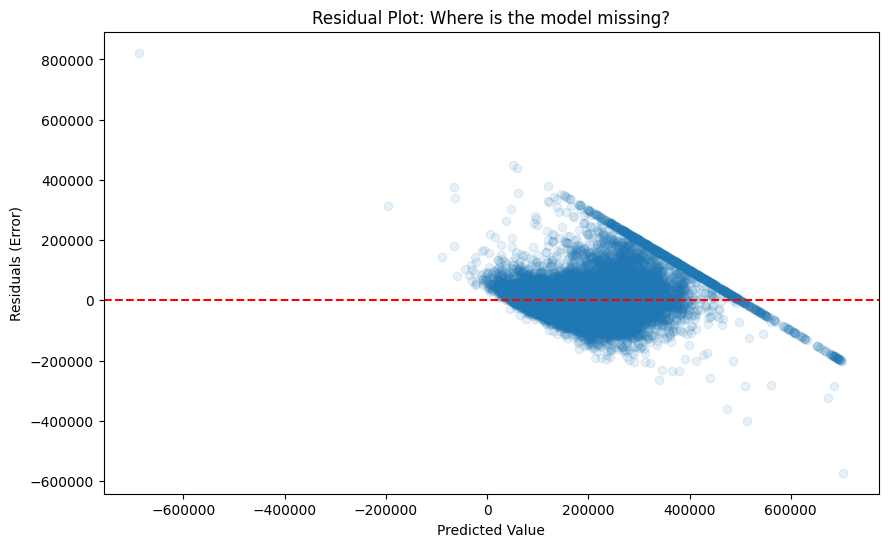

In [16]:
import matplotlib.pyplot as plt

# Let's fit the linear model to see its residuals
lin_reg.fit(X_train_prepared, y_train)
predictions = lin_reg.predict(X_train_prepared)
residuals = y_train - predictions

plt.figure(figsize=(10,6))
plt.scatter(predictions, residuals, alpha=0.1)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Value")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot: Where is the model missing?")
plt.show()

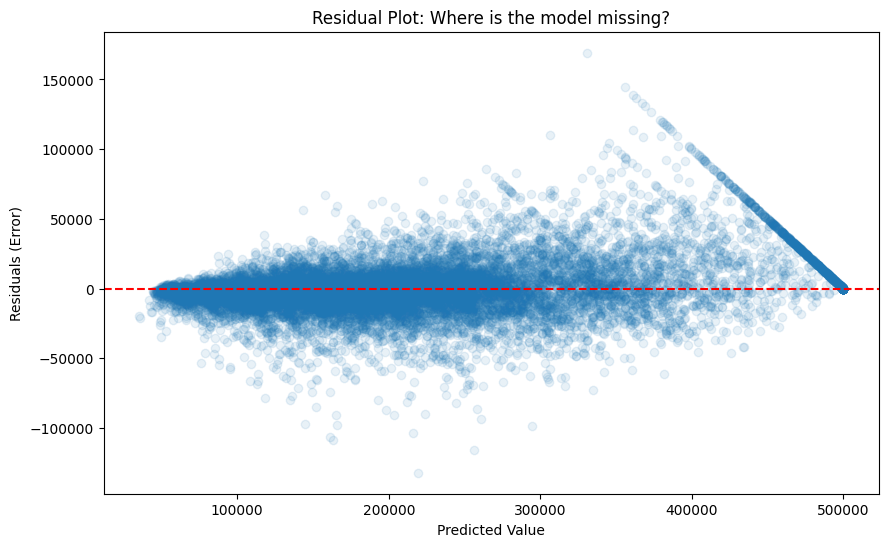

In [17]:
import matplotlib.pyplot as plt

# Let's fit the linear model to see its residuals
forest_reg.fit(X_train_prepared, y_train)
predictions = forest_reg.predict(X_train_prepared)
residuals = y_train - predictions

plt.figure(figsize=(10,6))
plt.scatter(predictions, residuals, alpha=0.1)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Value")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot: Where is the model missing?")
plt.show()

#### Actual vs. Predicted (The "Diagonal" Test)
This plot tells you if your model is biased. If the points are mostly below the line at the high end, your model is "under-predicting" expensive homes (common due to the $500k cap).

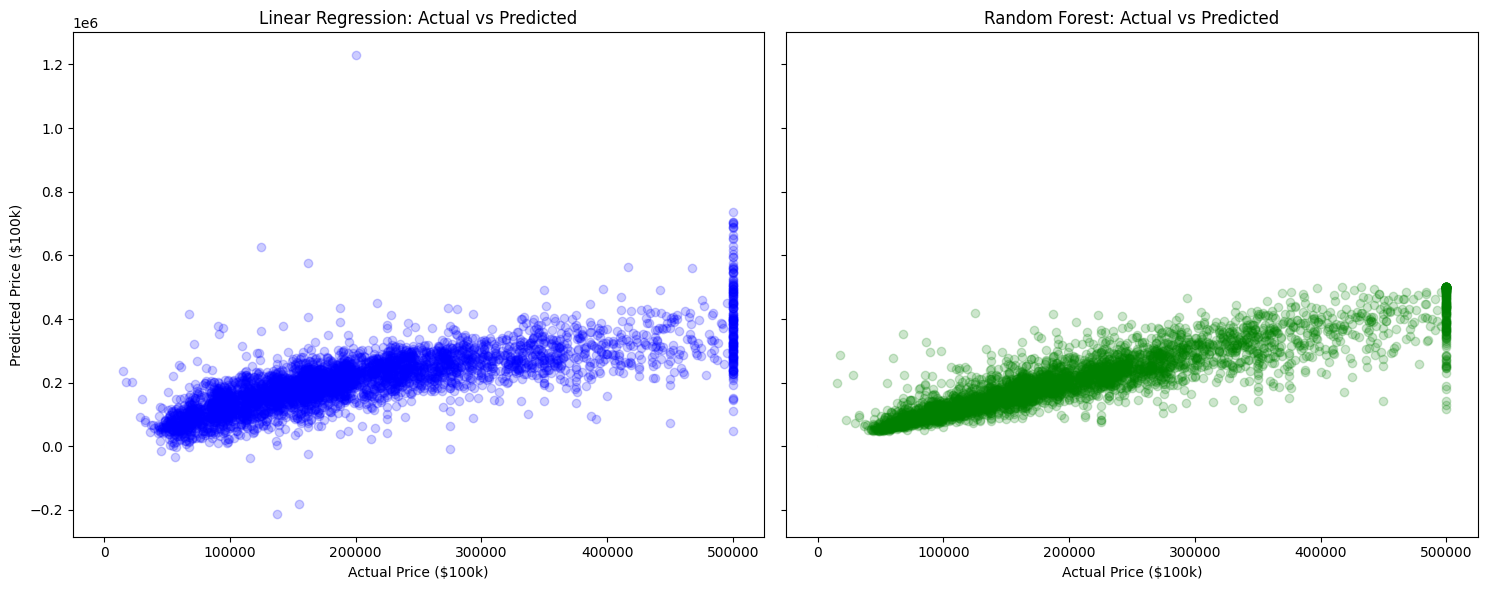

In [18]:
import matplotlib.pyplot as plt

# Get predictions from both models on the test set
lin_pred = lin_reg.predict(X_test_prepared)
forest_pred = forest_reg.predict(X_test_prepared)

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot Linear Regression
axes[0].scatter(y_test, lin_pred, alpha=0.2, color='blue')
axes[0].plot([0, 5], [0, 5], 'r--') # Diagonal line
axes[0].set_title("Linear Regression: Actual vs Predicted")
axes[0].set_xlabel("Actual Price ($100k)")
axes[0].set_ylabel("Predicted Price ($100k)")

# Plot Random Forest
axes[1].scatter(y_test, forest_pred, alpha=0.2, color='green')
axes[1].plot([0, 5], [0, 5], 'r--') # Diagonal line
axes[1].set_title("Random Forest: Actual vs Predicted")
axes[1].set_xlabel("Actual Price ($100k)")

plt.tight_layout()
plt.show()

#### Residual Distribution (The "Bell Curve" Test)
In a perfect world, your errors (residuals) should be Normally Distributed (a bell curve) centered at zero. If the curve is skewed, your model has a systematic bias.

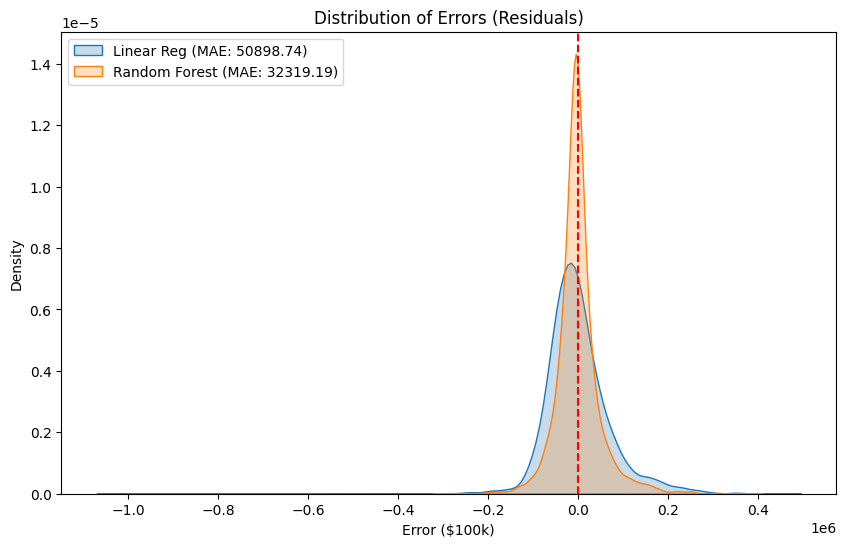

In [19]:
import seaborn as sns

# Calculate residuals
lin_residuals = y_test - lin_pred
forest_residuals = y_test - forest_pred

plt.figure(figsize=(10, 6))
sns.kdeplot(lin_residuals, label=f"Linear Reg (MAE: {mean_absolute_error(y_test, lin_pred):.2f})", fill=True)
sns.kdeplot(forest_residuals, label=f"Random Forest (MAE: {mean_absolute_error(y_test, forest_pred):.2f})", fill=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Errors (Residuals)")
plt.xlabel("Error ($100k)")
plt.legend()
plt.show()

#### Geographical Error Map (The "Spatial" Test)
Since this is California, we can see if the model fails in specific cities. For example, if the model consistently under-predicts in San Francisco, you might need a feature that specifically identifies "High-Tech Hubs."

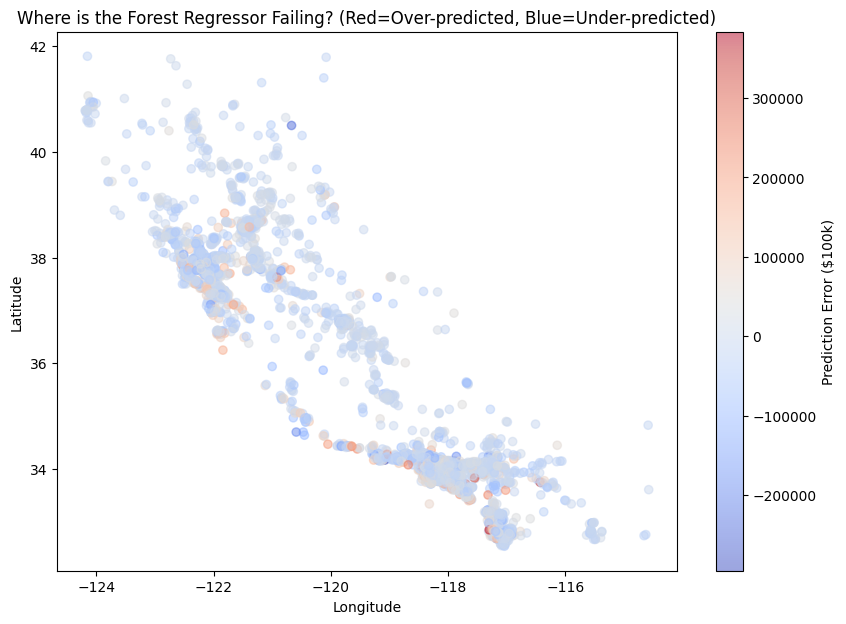

In [20]:
# Create a temporary dataframe for the test set errors
test_results = pd.DataFrame(X_test, columns=num_attribs)
test_results['error'] = forest_residuals

plt.figure(figsize=(10, 7))
plt.scatter(test_results['longitude'], test_results['latitude'], 
            c=test_results['error'], cmap='coolwarm', alpha=0.5)
plt.colorbar(label='Prediction Error ($100k)')
plt.title("Where is the Forest Regressor Failing? (Red=Over-predicted, Blue=Under-predicted)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Fune-tuning the Random Forest with a random search 

GridSearchCV is great for small search spaces, but for a Random Forest with many possible combinations, RandomizedSearchCV is the industry standard. It picks a random combination of features in each iteration, allowing you to cover a wider range of values in much less time.

#### 1. The Randomized Search Setup

We will tune the number of trees (n_estimators), the number of features considered at each split (max_features), and the depth of the trees.

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# 1. Define the parameter space
# 'randint' generates a random integer within the range for each iteration
param_distribs = {
    'n_estimators': randint(low=50, high=500),
    'max_features': randint(low=2, high=16), # We have 16 features now!
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(low=2, high=20)
}

# 2. Initialize the search
# n_iter=10 means it will try 10 random combinations
# cv=5 means 5-fold cross-validation for each combination
rnd_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distribs,
    n_iter=10, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    random_state=42,
    n_jobs=-1 # Use all available CPU cores
)

# 3. Run the search
rnd_search.fit(X_train_prepared, y_train)

/Users/davideferreri/Documents/GitHub/ML-and-AI/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': [None, 10, ...], 'max_features': <scipy.stats....t 0x11ab27650>, 'min_samples_split': <scipy.stats....t 0x11af55a90>, 'n_estimators': <scipy.stats....t 0x11aca1b90>}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_mean_absolute_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` f

#### 2. Evaluate the Best Parameters

Once the search is finished, we can see which combination of "knobs and dials" performed the best.

In [22]:
# Print the best parameters found
print("Best Parameters:", rnd_search.best_params_)

# Calculate the MAE of the best model found by the search
best_rf_mae = -rnd_search.best_score_
print(f"Best CV MAE: {best_rf_mae:.4f}")
print(f"Best CV Real Dollar Error: ${best_rf_mae * 100000:,.2f}")

Best Parameters: {'max_depth': 20, 'max_features': 7, 'min_samples_split': 3, 'n_estimators': 393}
Best CV MAE: 32475.8887
Best CV Real Dollar Error: $3,247,588,871.63


#### 3. Final Test on the "Vault" (The Test Set)

Now that we have our optimized model, it's time for the moment of truth: testing it on the data we've kept hidden since the very beginning.

In [24]:
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Get the best model
final_model = rnd_search.best_estimator_

# 2. Predict on the prepared test set
final_predictions = final_model.predict(X_test_prepared)

# 3. Final Metrics
final_mae = mean_absolute_error(y_test, final_predictions)
final_r2 = r2_score(y_test, final_predictions)

print("--- FINAL PRODUCTION RESULTS ---")
print(f"Final MAE: ${final_mae * 100000:,.2f}")
print(f"R2 Score: {final_r2:.4f} (The model explains {final_r2*100:.1f}% of price variance)")

--- FINAL PRODUCTION RESULTS ---
Final MAE: $3,200,869,008.93
R2 Score: 0.8185 (The model explains 81.9% of price variance)


### Example of how to host his project using FastAPI

#### Step A: Save your Pipeline
In your notebook, add a cell to save your full_pipeline and the final_model. Using joblib is better than pickle for large NumPy arrays.

In [ ]:
import joblib

# Save the entire pipeline (including the custom transformer)
joblib.dump(final_model, 'california_housing_model.pkl')
joblib.dump(full_pipeline, 'preprocessor_pipeline.pkl')

#### Step B: Create a FastAPI Application
Create a new file named main.py. This script will load your model and create an "endpoint" where users can send data.

In [ ]:
from fastapi import FastAPI
import joblib
import pandas as pd
from pydantic import BaseModel

app = FastAPI()

# Load the saved model and pipeline
model = joblib.load('california_housing_model.pkl')
preprocessor = joblib.load('preprocessor_pipeline.pkl')

class HouseFeatures(BaseModel):
    longitude: float
    latitude: float
    housing_median_age: float
    total_rooms: float
    total_bedrooms: float
    population: float
    households: float
    median_income: float
    ocean_proximity: str

@app.post("/predict")
def predict_price(features: HouseFeatures):
    # Convert input into a DataFrame
    input_df = pd.DataFrame([features.dict()])
    
    # Preprocess and Predict
    prepared_data = preprocessor.transform(input_df)
    prediction = model.predict(prepared_data)
    
    return {"predicted_median_house_value": float(prediction[0])}

#### Step C: Hosting Options
Render / Railway / Heroku (Easiest): You can connect your GitHub repo to these services. They will detect the requirements.txt and main.py and give you a public URL (e.g., my-house-api.render.com).

Streamlit (Best for Portfolios): If you want a visual UI instead of just an API, use Streamlit. It allows you to build a web dashboard in pure Python where users can move sliders for "Income" or "Rooms" and see the price change in real-time.

### Notebook Feedback & Suggested Additions
- **Handle Data Capping**: You noted the $500,001 cap in the median_house_value. This significantly biases your model (as seen in the "horizontal line" on your residual plots). I recommend either removing districts where the price is $500,000 to see how the model performs on "standard" homes or treating it as a censored regression problem.

- **Geographical Clusters**: Instead of just using raw Latitude and Longitude, you could add a K-Means Clustering step. This would group houses into "neighborhoods," which often captures price variations better than raw coordinates alone.

- **Log Transformation**: Housing prices are typically right-skewed. Taking the log of your target variable (median_house_value) before training can help models (especially Linear Regression) converge better and handle outliers more gracefully.

- **Check for Data Leakage**: Ensure that the median_income isn't leaking information. In some versions of this dataset, income is scaled. It’s perfect in your notebook, but always good to explicitly mention in your documentation.